In [202]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, norm, bartlett, ttest_ind, pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import anova_lm
import numpy as np
import seaborn as sns

In [4]:
file_path = "OT3 OT4 2019-2024June _noFilter.xlsx"
sheet_name = "Data"
main = pd.read_excel(file_path, sheet_name=sheet_name)

In [5]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Columns: 108 entries, Theatre to Start Finish Journey
dtypes: float64(46), int64(10), object(52)
memory usage: 2.8+ MB


In [6]:
main['Paint Draping Start DT']


0                       NaN
1                       NaN
2                       NaN
3       2023/12/18 15:58:00
4       2021/05/27 11:23:00
               ...         
3421    2020/02/28 09:56:00
3422    2020/04/01 11:06:00
3423    2023/04/20 06:15:00
3424                    NaN
3425    2022/05/16 09:46:00
Name: Paint Draping Start DT, Length: 3426, dtype: object

In [ ]:
# Description of Cardio-Thoracic Surgery

## Original data
main.info()

## Procedure Description values of original data
print(sorted(main['ProcedureDescription'].unique()))

In [81]:
cardiac_select = ["AICD IMPLANT / REMOVAL", "AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND", "AORTIC VALVE SURGERY", "ASD", "CABG", "Coronary artery bypass, using 1 LIMA graft", "Extracorporeal membrane oxygenation [ECMO]", "Insertion of left ventricular assist device", "Insertion of permanent epicardial electrode by tho", "LUNG TRANSPLANT", "MITRAL VALVE SURGERY", "Other intrathoracic procedures on heart with cardi", "PERICARDIAL WINDOW", "PULMONARY VALVE SURGERY", "Removal of sternal wire", "Repair of diaphragmatic hernia, thoracic approach", "RE-STERNOTOMY", "TRICUSPID VALVE SURGERY", "VENTRICULAR ASSIST DEVICE"]

In [73]:
(main['ProcedureDescription'] == cardiac_select[0]).sum()

22

In [ ]:
main['In Anaesthetic Room DT'] = main['In Anaesthetic Room DT'].fillna(main['In Operating Theatre DT'])
main['Dressing Applied DT'] = main['Dressing Applied DT'].fillna(main['Patient Return Ward DT'])

main['In Anaesthetic Room DT'] = pd.to_datetime(main['In Anaesthetic Room DT'])
main['Dressing Applied DT'] = pd.to_datetime(main['Dressing Applied DT'])

main['In Holding Bay DT'] = pd.to_datetime(main['In Holding Bay DT'])
main['In Operating Theatre DT'] = pd.to_datetime(main['In Operating Theatre DT'])
main['Anaesthetic Start DT'] = pd.to_datetime(main['Anaesthetic Start DT'])
# main['Paint Draping Start DT'] = pd.to_datetime(main['Paint Draping Start DT'], format='mixed')
main['Instrument To Skin DT'] = pd.to_datetime(main['Instrument To Skin DT'])
main['Ready PACU Room DT'] = pd.to_datetime(main['Ready PACU Room DT'])
main['Patient Return Ward DT'] = pd.to_datetime(main['Patient Return Ward DT'])
main['Discharge DT'] = pd.to_datetime(main['Discharge DT'], format ='mixed')
main['Send For Patient DT'] = pd.to_datetime(main['Send For Patient DT'])
main['Patient Ready Depart PACU DT'] = pd.to_datetime(main['Patient Ready Depart PACU DT'])

In [ ]:
main[startTime] = pd.to_datetime(main['In Anaesthetic Room DT']).dt.time
main[dressingTime] = pd.to_datetime(main['Dressing Applied DT']).dt.time

main[startLate] = np.where((main[TheatreDay].isin(['MON', 'TUE', 'THU', 'FRI'])) & (main[startTime].dt.hour * 3600 + main[startTime].dt.minute * 60 + main[startTime].dt.second - 29700 > 0), 1, 
                            np.where((main[TheatreDay] == 'WED') & (main[startTime].dt.hour * 3600 + main[startTime].dt.minute * 60 + main[startTime].dt.second - 32400 > 0), 1, 0))

In [82]:
main = main.astype({col: 'category' for col in main.select_dtypes('object').columns})

main = pd.DataFrame(main)
selected_columns = [col for col in main.columns if col not in ['PatientName', 'EpisodeNumber', 'MRN', 'Theatre', 'WL Referral Date', 'Specialty Description Mater', 'Consultant Name']]
print(pd.DataFrame(main.iloc[:10, selected_columns]).to_markdown(caption='Table of cardiac selected data'))

IndexError: .iloc requires numeric indexers, got ['FirstPatientInTheatre' 'ProcedureCode' 'ProcedureDescription'
 'Admission DT' 'Referred PreOp Date' 'PreOp Date' 'Send For Patient DT'
 'In Holding Bay DT' 'In Anaesthetic Room DT' 'Anaesthetic Start DT'
 'In Operating Theatre DT' 'Paint Draping Start DT'
 'Instrument To Skin DT' 'Dressing Applied DT' 'Ready PACU Room DT'
 'In PACU DT' 'Patient Ready Depart PACU DT' 'Patient Ready ICUHDU DT'
 'Patient Return Ward DT' 'Discharge DT' 'Discharge Home Time'
 'EmergencyTMS' 'Theatre Month' 'EpisodeType' 'AdmitWard' 'TheatreDay'
 'Theatre Year' 'Theatre Date' 'In Operating Theatre Flag'
 'InPacu to ReadyICUHDU Flag' 'Patient Return to Ward Location'
 'StartDelayReason1' 'StartDelayReason2' 'StartDelayReason3'
 'UnderRunsReason1' 'UnderRunsReason2' 'UnderRunsReason3'
 'EmergencyCategory' 'Robot Journey Flag' 'Console Docked DT'
 'Console Commenced DT' 'Console Undocked DT' 'Console Docked Flag'
 'Console Undocked Flag' 'ConsoleDocked to ConsoleCommenced Flag'
 'ConsoleCommenced to ConsoleUndocked Flag' 'IP Discharge Destination'
 'ED Discharge Destination' 'RIP Indicator' 'SOAGroup' 'SOA'
 'EpisodeStatus' 'StartDelayTransDate' 'TeamSurgeon' 'Count PreOp'
 'Procedure Wait Time (Days)' 'Pre-Op Notice (Days)'
 'SendForPatient to InHoldingBay (Mins) Ave Yes'
 'InHoldingBay to AnaesRoom (Mins) FlagYes' 'Anaes Wait (Mins)'
 'AnaesStart to ReadyTfrTheatre (Mins) Ave Yes'
 'AnaesStart to InOpTheatre (Mins) Ave In OT Yes'
 'AnaesStart to ReadyTransferTheatre (Mins)'
 'ReadyTransferTheatre to InOpTheatre (Mins)'
 'InOpTheatre to PaintDrape (Mins) Ave Drape Yes'
 'Theatre Wait (Mins) Ave Inst to skin and op Yes'
 'PaintDrape to InstrToSkin (Mins) Ave Skin Yes'
 'InstrToSkin to DressAppl (Mins) Ave Dressing Yes'
 'DressAppl to ReadyPACU (Mins) Ave Ready Yes'
 'ReadyDepartPacu to ReturnWard (mins) Ave'
 'Referred Pre-Op to Pre-Op (Days)' 'Theatre Readmission Count'
 'Theatre 1st Readmission Count' 'Theatre Readmission Days'
 'Anaes Turnaround Time (Mins)'
 'Surgical Turnaround Time (Mins) Ave Prev Dressing Yes' 'Count'
 'No StartDelay Reason1' 'No StartDelay Reason2' 'No StartDelay Reason3'
 'No UnderRun Reason1' 'No UnderRun Reason2' 'No UnderRun Reason3'
 'Cases Docked and Undocked' 'ConsoleDocked to ConsoleCommenced (mins)'
 'ConsoleCommenced to ConsoleUndocked (mins)' 'PreOP To In Theatre Hours'
 'Anaes Turnaround Time (Mins) Ave In Anaes Room Yes' 'Count In PACU'
 'Count IN PACU OOH No' 'Count IN PACU OOH Yes'
 'Procedure Wait Time (Days) Average' 'Anaes Journey Average'
 'Consultant Journey Average' 'Robot Journey Average'
 'Theatre Journey Average' 'PACU Journey Average'
 'Return to Ward Journey Average' 'Patient Journey Average'
 'Ward Journey Average' 'Start Finish Journey']

In [25]:
len("2020/08/18 ")

11

In [27]:
'2020/08/18 24:00:00'[:11]

'2020/08/18 '

In [28]:
'2020/08/18 24:00:00'[13:]

':00:00'

In [29]:
'2020/08/18 24:00:00'[11:13]

'24'

In [31]:
main['Discharge DT']

0       2021/10/15 11:34:00
1       2023/02/20 16:31:00
2       2024/03/28 17:08:00
3       2023/12/19 19:00:00
4       2021/05/27 16:37:00
               ...         
3421    2020/04/29 14:54:00
3422    2020/04/29 14:54:00
3423    2023/06/29 15:26:00
3424    2021/05/13 18:58:00
3425    2022/05/25 09:57:00
Name: Discharge DT, Length: 3426, dtype: object

In [55]:
# main['Discharge DT'].apply(pd.notna).apply(lambda x: x[:11] + '00' + x[13:] if x[11:13] == '24' else x)

TypeError: 'bool' object is not subscriptable

In [76]:
# main['Discharge DT'].apply(lambda x: x[:11] + '00' + x[13:] if x[11:13] == '24' and pd.notna(x) else x)

In [21]:
main['Paint Draping Start DT'][2564]

'2020/07/22 09:51:00'

In [70]:
# _ = main
# for col in cardiac_select:
#     _ = _[_['ProcedureDescription'] == col]

In [75]:
# main.loc[(main['ProcedureDescription'] == cardiac_select[0]) | (main['ProcedureDescription'] == cardiac_select[1]) | (main['ProcedureDescription'] == cardiac_select[2])]

,Theatre,Specialty Description Mater,FirstPatientInTheatre,ProcedureCode,ProcedureDescription,Consultant Name,WL Referral Date,Admission DT,Referred PreOp Date,PreOp Date,...,Procedure Wait Time (Days) Average,Anaes Journey Average,Consultant Journey Average,Robot Journey Average,Theatre Journey Average,PACU Journey Average,Return to Ward Journey Average,Patient Journey Average,Ward Journey Average,Start Finish Journey
359,T03-Theatre 3,Cardio-Thoracic Surgery,0,MHCT005,AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND,CTS,NaN,2020/03/03 22:44:00,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,T03-Theatre 3,Cardio-Thoracic Surgery,0,MHCT005,AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND,CTS,NaN,2021/04/08 15:36:00,2021/02/16,2021/02/26,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,T03-Theatre 3,Cardio-Thoracic Surgery,0,MHCT005,AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND,CTS,NaN,2022/09/22 22:55:00,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,321.0,NaN,NaN
362,T03-Theatre 3,Cardio-Thoracic Surgery,0,MHCT005,AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND,CTS,NaN,2023/01/27 23:09:00,NaN,NaN,...,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
363,T03-Theatre 3,Cardio-Thoracic Surgery,0,MHCT005,AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND,CTS,NaN,2023/03/13 18:24:00,2023/02/21,2023/03/07,...,125,55.0,NaN,NaN,NaN,NaN,NaN,381.0,36.0,646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,T04-Theatre 4,Cardio-Thoracic Surgery,1,MHCT018,AICD IMPLANT / REMOVAL,CTS,NaN,2020/09/22 16:52:00,2024/03/12,2024/04/09,...,301,39.0,205.0,NaN,110.0,95.0,18.0,290.0,28.0,NaN
3268,T04-Theatre 4,Cardio-Thoracic Surgery,1,MHCT018,AICD IMPLANT / REMOVAL,CTS,NaN,2020/11/11 20:59:00,NaN,NaN,...,0,26.0,215.0,NaN,153.0,62.0,13.0,291.0,37.0,NaN
3269,T04-Theatre 4,Cardio-Thoracic Surgery,1,MHCT018,AICD IMPLANT / REMOVAL,CTS,NaN,2022/02/18 07:35:00,NaN,NaN,...,148,NaN,138.0,NaN,NaN,NaN,21.0,199.0,NaN,91.0
3270,T04-Theatre 4,Cardio-Thoracic Surgery,1,MHCT018,AICD IMPLANT / REMOVAL,CTS,NaN,2023/05/31 20:27:00,NaN,NaN,...,7,30.0,145.0,NaN,76.0,69.0,NaN,NaN,39.0,NaN


In [86]:
# Description of Cardiac with First Patient

main_processed = main.loc[main['ProcedureDescription'].isin(cardiac_select)]
main_processed = main_processed.loc[main_processed['FirstPatientInTheatre'] == 1]

# print(pd.DataFrame(main_processed.iloc[:10, selected_columns]))


## Late start

main_processed['TheatreDay'] = pd.Categorical(main_processed['TheatreDay'], categories=['MON','TUE','WED','THU','FRI','SAT','SUN'], ordered=True)
main_processed['Theatre Month'] = pd.Categorical(main_processed['Theatre Month'], categories=['January','February','March','April','May','June','July','August','September','October','November','December'], ordered=True)
main_processed['Theatre Year'] = pd.Categorical(main_processed['Theatre Year'], categories=['2020','2021','2022','2023','2024'], ordered=True)

In [87]:
# Description of Elective Cardiac

cardiac = main.loc[main['ProcedureDescription'].isin(cardiac_select)]
cardiac_elective = cardiac.loc[cardiac['EmergencyTMS'] == 'Elective']

# ```{r tables-cardiacElective, echo=FALSE}
# knitr::kable(cardiac_elective[1:10, !names(main) %in% c("PatientName","EpisodeNumber","MRN","Theatre","WL Referral Date", "Specialty Description Mater","Consultant Name")], caption = 'Table of **Elective Surgery** in *Cardiac Selected* data')
# ```

## Duration (mins) from "Start Time - In Anaes Room" to "Dressing Time"
# Assuming 'cardiac_elective' is a pandas DataFrame
cardiac_elective['InAnaesToDressingTime'] = cardiac_elective['In Anaesthetic Room DT'].apply(pd.Timestamp) - cardiac_elective['Dressing Applied DT'].apply(pd.Timestamp)
cardiac_elective['InAnaesToDressingMins'] = cardiac_elective['InAnaesToDressingTime'].dt.total_seconds() / 60

print(cardiac_elective['InAnaesToDressingMins'].info())
print(cardiac_elective['InAnaesToDressingMins'].describe())

<class 'pandas.core.series.Series'>
Index: 1823 entries, 11 to 3422
Series name: InAnaesToDressingMins
Non-Null Count  Dtype  
--------------  -----  
1469 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB
None
count    1469.000000
mean     -363.092580
std       116.199594
min     -2022.000000
25%      -409.000000
50%      -360.000000
75%      -308.000000
max       438.000000
Name: InAnaesToDressingMins, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_15160\2904199180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardiac_elective['InAnaesToDressingTime'] = cardiac_elective['In Anaesthetic Room DT'].apply(pd.Timestamp) - cardiac_elective['Dressing Applied DT'].apply(pd.Timestamp)
C:\Users\User\AppData\Local\Temp\ipykernel_15160\2904199180.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardiac_elective['InAnaesToDressingMins'] = cardiac_elective['InAnaesToDressingTime'].dt.total_seconds() / 60


In [ ]:
# Nominal data

## Data exploration

def nominalVar(nominal, nominal_name):
    print(sorted(set(nominal)))
    
    df_nominal = pd.DataFrame(nominal).value_counts().reset_index()
    df_nominal.columns = ["name", "freq"]
    print(f"Table of frequency of {nominal_name}:\n")
    print(df_nominal.sort_values("freq", ascending=False))

In [88]:
def nominal_pareto(nominal, nominal_name):
    df_nominal = pd.DataFrame(nominal).value_counts().reset_index()
    df_nominal.columns = ["nominalValue", "freq"]
    df_nominal['freq %'] = df_nominal['freq']/df_nominal['freq'].sum()
      
    xlim_df = len(df_nominal["nominalValue"].unique())
    ylim_df = df_nominal["freq"].sum()
    y80per = 80 * df_nominal["freq %"].sum()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax2 = ax.twinx()
    ax.plot(df_nominal["nominalValue"], (df_nominal["freq"].cumsum() / df_nominal["freq"].sum())*100, color="red")
    sns.barplot(x="nominalValue", y="freq", data=df_nominal, palette=["blue", "lightblue"], ax=ax2, 
                order=df_nominal.sort_values("freq", ascending=False).nominalValue)
    ax.axhline(y=y80per, color="darkblue", linestyle="--", linewidth=0.5)
    ax.set_title(f"{nominal_name} Pareto")
    ax.set_xlabel(nominal_name)
    ax.set_ylabel("Cumulative Percent")
    ax.tick_params(axis='x', rotation=90, labelsize=7)
    plt.savefig(f"{nominal_name}_pareto.pdf")
    plt.show()

In [ ]:
def nominal_corNominal(nominal1, nominal1_name, nominal2, nominal2_name):
    nominal1 = pd.Series(nominal1, name=nominal1_name)
    nominal2 = pd.Series(nominal2, name=nominal2_name)
    
    contingency_table = pd.crosstab(nominal1, nominal2)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(contingency_table)
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.4f}")

In [142]:
df_nominal = pd.DataFrame(main_processed['TheatreDay']).value_counts().reset_index()

df_nominal.columns = ["nominalValue", "freq"]
df_nominal['freq %'] = df_nominal['freq']/df_nominal['freq'].sum()

In [143]:
df_nominal

,nominalValue,freq,freq %
0,TUE,348,0.257969
1,FRI,319,0.236471
2,MON,269,0.199407
3,WED,210,0.155671
4,THU,131,0.097109
5,SAT,37,0.027428
6,SUN,35,0.025945


In [138]:
df_nominal["freq"].cumsum() / df_nominal["freq"].sum()

0    0.257969
1    0.494440
2    0.693847
3    0.849518
4    0.946627
5    0.974055
6    1.000000
Name: freq, dtype: float64

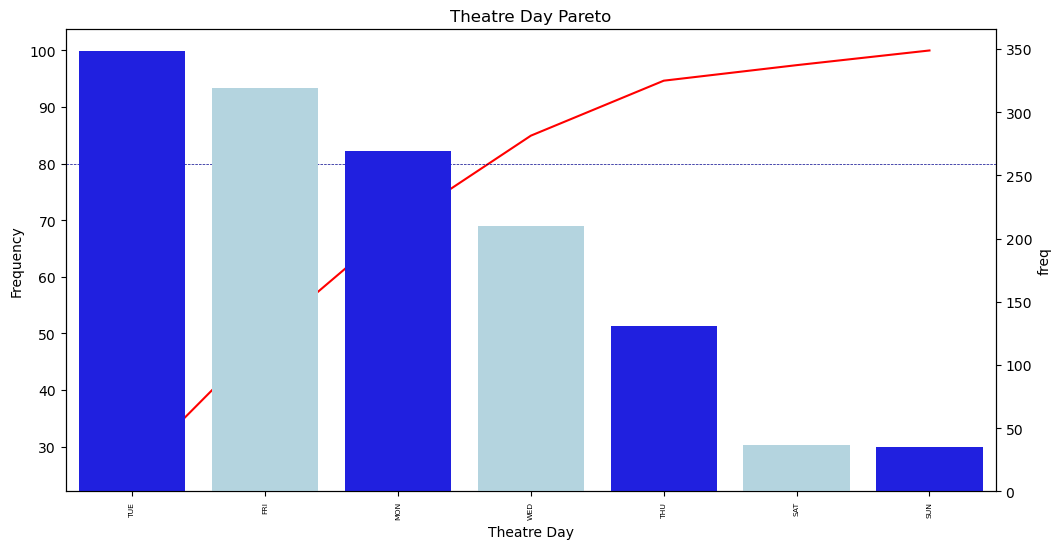

In [185]:
nominal_pareto(main_processed['TheatreDay'], "Theatre Day")

In [105]:
nominal_corNominal(main_processed['ProcedureDescription'], "Procedure Description", main_processed['TheatreDay'], "Theatre Day")

Theatre Day                                         MON  TUE  WED  THU  FRI  \
Procedure Description                                                         
AICD IMPLANT / REMOVAL                                1    2    2    1    2   
AORTIC REPAIR/REPLACE ASC/ARCH/DESCEND               12   11    8    8    7   
AORTIC VALVE SURGERY                                 45   54   41   25   56   
ASD                                                   7    1    2    0    2   
CABG                                                148  228  120   78  197   
Coronary artery bypass, using 1 LIMA graft            1    0    0    0    0   
Extracorporeal membrane oxygenation [ECMO]            1    0    0    2    1   
Insertion of left ventricular assist device           4    0    0    0    0   
LUNG TRANSPLANT                                      11   13   10    5    8   
MITRAL VALVE SURGERY                                 12   32   13    7   31   
Other intrathoracic procedures on heart with cardi  

In [199]:
def scale_norm(scale, scale_name, datetime=None):
    if datetime is None:
        datetime = cardiac_elective['Theatre Date']
    datetime = pd.to_datetime(datetime, format="%d/%m/%Y")  # datetime is Theatre date
    np.random.seed(123)
    df_scale = pd.DataFrame({'scale': scale, 'datetime': datetime})
    df_scale = df_scale.dropna()
    df_scale['year_month'] = df_scale['datetime'].dt.strftime('%Y-%m')
    df_scale['year'] = df_scale['datetime'].dt.strftime('%Y')
    df_scale['month'] = df_scale['datetime'].dt.strftime('%m')
    df_scale['day'] = df_scale['datetime'].dt.day_name()
    df_scale['year_month_day'] = df_scale['year_month'] + ' ' + df_scale['day']
    print(df_scale.info())

    # Histogram
    bw = 2 * df_scale['scale'].std() / len(df_scale['scale']) ** (1/3)
    min_hist = df_scale['scale'].min()
    max_hist = df_scale['scale'].max()
    print(f"binwidth = {bw}")
    print(f"Minimum of scale = {min_hist}")
    print(f"Maximum of scale = {max_hist}")

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(df_scale['scale'], bins=int(np.ceil((max(df_scale['scale']) - min(df_scale['scale'])) / bw)), 
        color=df_scale['month'].map(plt.get_cmap('tab10')), 
        edgecolor='white', alpha=0.7)

    # Plot vertical lines for mean and median
    for month in df_scale['month'].unique():
        ax.axvline(df_scale.loc[df_scale['month'] == month, 'scale'].mean(), 
                   color=plt.get_cmap('tab10')(df_scale['month'].unique().tolist().index(month)), 
                   linestyle='dashed', linewidth=1)
        ax.axvline(df_scale.loc[df_scale['month'] == month, 'scale'].median(), 
                   color=plt.get_cmap('tab10')(df_scale['month'].unique().tolist().index(month)), 
                   linestyle='dotted', linewidth=1)

    # Plot density curves
    for month in df_scale['month'].unique():
        sns.kdeplot(df_scale.loc[df_scale['month'] == month, 'scale'], 
                    color=plt.get_cmap('tab10')(df_scale['month'].unique().tolist().index(month)), 
                    label=month, linewidth=1, alpha=0.5)

    # Set labels and title
    ax.set_xlabel(scale_name)
    ax.set_ylabel('Freq')
    ax.set_title(f'Monthly Distribution of {scale_name}')
    ax.legend(loc='upper center')
    ax.set_facecolor('white')
    plt.show()

In [193]:
def scale_norm(scale, scale_name, datetime=None):
    if datetime is None:
        datetime = cardiac_elective['Theatre Date']
    datetime = pd.to_datetime(datetime, format="%d/%m/%Y")  # datetime is Theatre date
    np.random.seed(123)
    df_scale = pd.DataFrame({'scale': scale, 'datetime': datetime})
    df_scale = df_scale.dropna()
    df_scale['year_month'] = df_scale['datetime'].dt.strftime('%Y-%m')
    df_scale['year'] = df_scale['datetime'].dt.strftime('%Y')
    df_scale['month'] = df_scale['datetime'].dt.strftime('%m')
    df_scale['day'] = df_scale['datetime'].dt.day_name()
    df_scale['year_month_day'] = df_scale['year_month'] + ' ' + df_scale['day']
    print(df_scale.info())

    # Histogram
    bw = 2 * df_scale['scale'].std() / len(df_scale['scale']) ** (1/3)
    min_hist = df_scale['scale'].min()
    max_hist = df_scale['scale'].max()
    print(f"binwidth = {bw}")
    print(f"Minimum of scale = {min_hist}")
    print(f"Maximum of scale = {max_hist}")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=df_scale, x="scale", binwidth=bw, color="gray", alpha=0.7, ax=ax)
    ax.plot(np.linspace(min_hist, max_hist, 100), 
            norm.pdf(np.linspace(min_hist, max_hist, 100), 
                          df_scale['scale'].mean(), df_scale['scale'].std()), 
            color="blue", linewidth=2)
    ax.axvline(df_scale['scale'].mean(), color="red", linestyle="dashed", linewidth=2)
    ax.axvline(df_scale['scale'].median(), color="green", linestyle="dotted", linewidth=2)
    sns.kdeplot(data=df_scale, x="scale", color="red", linewidth=2, alpha=0.5, ax=ax)
    ax.set_xlabel(scale_name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {scale_name}")
    plt.show()
    
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    ax1.hist(df_scale['scale'], bins=int(np.ceil((max(df_scale['scale']) - min(df_scale['scale'])) / bw)), 
        color=df_scale['month'].map(plt.get_cmap('tab10')), 
        edgecolor='white', alpha=0.7)

    # Plot vertical lines for mean and median
    for month in df_scale['month'].unique():
        ax.axvline(df_scale.loc[df_scale['month'] == month, 'scale'].mean(), 
                   color=plt.get_cmap('tab10')(df_scale['month'].unique().tolist().index(month)), 
                   linestyle='dashed', linewidth=1)
        ax.axvline(df_scale.loc[df_scale['month'] == month, 'scale'].median(), 
                   color=plt.get_cmap('tab10')(df_scale['month'].unique().tolist().index(month)), 
                   linestyle='dotted', linewidth=1)

    # Plot density curves
    for month in df_scale['month'].unique():
        sns.kdeplot(df_scale.loc[df_scale['month'] == month, 'scale'], 
                    color=plt.get_cmap('tab10')(df_scale['month'].unique().tolist().index(month)), 
                    label=month, linewidth=1, alpha=0.5)

    # Set labels and title
    ax.set_xlabel(scale_name)
    ax.set_ylabel('Freq')
    ax.set_title(f'Monthly Distribution of {scale_name}')
    ax.legend(loc='upper center')
    ax.set_facecolor('white')
    plt.show()

    # Box plot
    ## Box plot for year
    df_scale_mutate_y = df_scale.groupby("year")["scale"].agg(["mean", "median"]).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="year", y="mean", data=df_scale_mutate_y, palette="Set2", ax=ax)
    ax.scatter(df_scale_mutate_y["year"], df_scale_mutate_y["mean"], color="darkred", s=50)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Mean of {scale_name}")
    ax.set_title(f"Box plot of {scale_name} - average over years")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="year", y="median", data=df_scale_mutate_y, palette="Set2", ax=ax)
    ax.scatter(df_scale_mutate_y["year"], df_scale_mutate_y["median"], color="darkred", s=50)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Median of {scale_name}")
    ax.set_title(f"Box plot of {scale_name} - median over years")
    
    plt.xticks(rotation=90)
    plt.show()
    
    ## Box plot for month
    df_scale_mutate_m = (df_scale
        .groupby("month")
        .agg(mean_gr=("scale", "mean"), median_gr=("scale", "median"))
        .reset_index()
    )
    print(df_scale_mutate_m.head())

    bxp_mean_m = (sns.boxplot(x="month", y="mean_gr", data=df_scale_mutate_m, palette="Set3")
        .set_title(f"Box plot of {scale_name} - average over months")
        .set(xlabel=None, ylabel=None))
    
    bxp_median_m = (sns.boxplot(x="month", y="median_gr", data=df_scale_mutate_m, palette="Set3")
        .set_title(f"Box plot of {scale_name} - median over months")
        .set(xlabel=None, ylabel=None))

    plt.xticks(rotation=90)
    plt.show()
    
    ## Box plot for year & month
    df_scale_mutate_ym = (
        df_scale
        .groupby('year_month')
        .agg(mean_gr=('scale', 'mean'), median_gr=('scale', 'median'))
        .reset_index()
)

    print(df_scale_mutate_ym.head())

    bxp_mean_ym = (
        sns.boxplot(x='year_month', y='mean_gr', data=df_scale_mutate_ym, palette="Set2")
        .set_title(f"Box plot of {scale_name} as average over year_month")
        .set(xlabel=None, ylabel=None)
    )
    
    bxp_median_ym = (
        sns.boxplot(x='year_month', y='median_gr', data=df_scale_mutate_ym, palette="Set2")
        .set_title(f"Box plot of {scale_name} as median over year_month")
        .set(xlabel=None, ylabel=None)
    )
    
    plt.xticks(rotation=90)
    plt.show()
    
    # QQplot
    ## For year
    qq_mean_y = sns.qqplot(df_scale_mutate_y['mean_gr'])
    plt.title(f"{scale_name} QQ plot average over years")
    
    qq_median_y = sns.qqplot(df_scale_mutate_y['median_gr'])
    plt.title(f"{scale_name} QQ plot median over years")
    
    ## For month
    qq_mean_m = sns.qqplot(df_scale_mutate_m['mean_gr'])
    plt.title(f"{scale_name} QQ plot average over months")
    
    qq_median_m = sns.qqplot(df_scale_mutate_m['median_gr'])
    plt.title(f"{scale_name} QQ plot average over months")
    
    ## For year & month
    qq_mean_ym = sns.qqplot(df_scale_mutate_ym['mean_gr'])
    plt.title(f"{scale_name} QQ plot average over year_month")
    
    qq_median_ym = sns.qqplot(df_scale_mutate_ym['median_gr'])
    plt.title(f"{scale_name} QQ plot average over year_month")

    plt.show()
    
    # Normality test
    df_scaleNorm = df_scale['scale']
    shapiro_result = shapiro(df_scaleNorm)

    print(shapiro_result)

<class 'pandas.core.frame.DataFrame'>
Index: 1469 entries, 11 to 3422
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   scale           1469 non-null   float64       
 1   datetime        1469 non-null   datetime64[ns]
 2   year_month      1469 non-null   object        
 3   year            1469 non-null   object        
 4   month           1469 non-null   object        
 5   day             1469 non-null   object        
 6   year_month_day  1469 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 91.8+ KB
None
binwidth = 20.4437553152796
Minimum of scale = -2022.0
Maximum of scale = 438.0


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

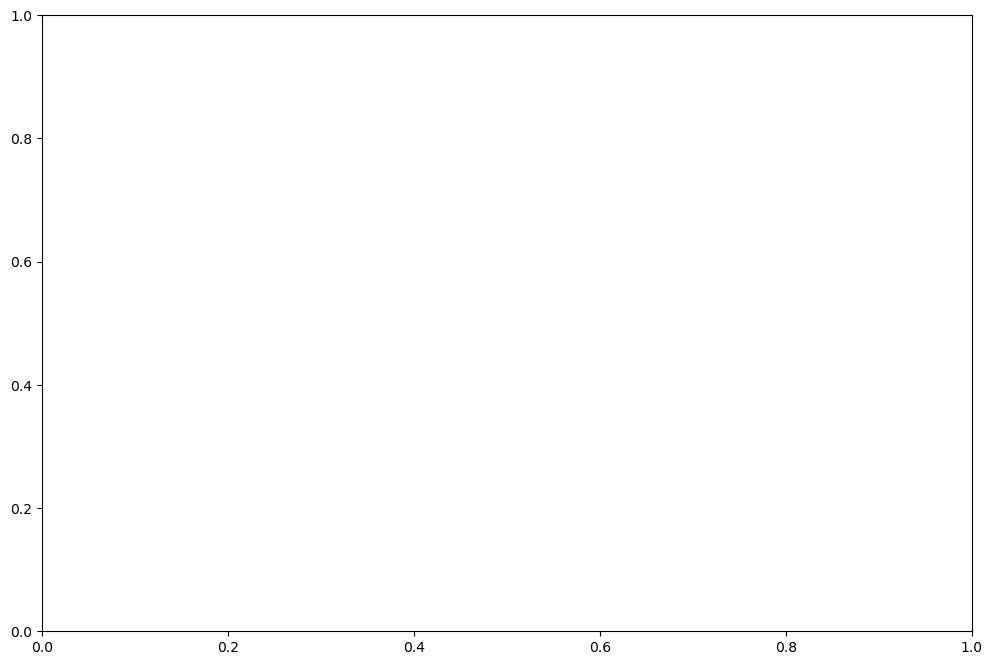

In [200]:
scale_norm(cardiac_elective['InAnaesToDressingMins'], "From In Anaes Room To Dressing Applied (mins)")

In [203]:
def scale_corNominal(scale, scale_name, nominal, nominal_name):
    df_scaleNominal = pd.DataFrame({'scale': scale, 'nominal': nominal})
    df_scaleNominal = df_scaleNominal.dropna()

    # Statistical test (nominal and scale)
    bt = bartlett(df_scaleNominal['scale'], df_scaleNominal['nominal'])
    print(bt)
    if bt.pvalue > 0.05 or bt.pvalue == 0.05:
        model = ols('scale ~ C(nominal)', data=df_scaleNominal).fit()
        print(model.summary())
    else:
        mc = MultiComparison(df_scaleNominal['scale'], df_scaleNominal['nominal'])
        dunn_result = mc.allpairtest(method='bonferroni')
        print(dunn_result)
        

In [216]:
print(cardiac_elective.dtypes)
print(cardiac_elective['TheatreDay'].dtype)
print(cardiac_elective['InAnaesToDressingMins'].dtype)

Theatre                               category
Specialty Description Mater           category
FirstPatientInTheatre                    int64
ProcedureCode                         category
ProcedureDescription                  category
                                    ...       
Patient Journey Average                float64
Ward Journey Average                   float64
Start Finish Journey                   float64
InAnaesToDressingTime          timedelta64[ns]
InAnaesToDressingMins                  float64
Length: 110, dtype: object
category
float64


In [204]:
scale_corNominal(cardiac_elective['InAnaesToDressingMins'], "Time From 'In Anaes' To 'Dressing Applied' (mins)", cardiac_elective['TheatreDay'], "Theatre Day")

TypeError: 'Categorical' with dtype category does not support reduction 'var'

In [205]:
def scale_corBinary(scale, scale_name, binary, binary_name):
    df_scaleBinary = pd.DataFrame({'scale': scale, 'binary': binary})
    
    # Statistical test (binary and scale)
    bt = bartlett(df_scaleBinary['scale'], df_scaleBinary['binary'])
    print(bt)
    if bt.pvalue > 0.05 or bt.pvalue == 0.05:
        ttest_equal = ttest_ind(df_scaleBinary['scale'], df_scaleBinary['binary'], equal_var=True)
        print(ttest_equal)
    else:
        ttest_notequal = ttest_ind(df_scaleBinary['scale'], df_scaleBinary['binary'], equal_var=False)
        print(ttest_notequal)

In [208]:
# test
scale_corBinary(cardiac_elective['InAnaesToDressingMins'], "In Anaes To Dressing Applied (mins)", cardiac_elective['FirstPatientInTheatre'], "First Patient")

BartlettResult(statistic=17472.929337773407, pvalue=0.0)
TtestResult(statistic=nan, pvalue=nan, df=nan)


In [209]:
def scale_corOrdinal(scale, scale_name, ordinal, ordinal_name):
    df_scaleOrdinal = pd.DataFrame({'scaleValue': scale, 'ordinalValue': ordinal})
    
    # Correlation matrix
    df_scaleOrdinal = df_scaleOrdinal.apply(pd.to_numeric, errors='ignore')
    corr_test = df_scaleOrdinal.corr(method='spearman')
    print(corr_test)
    
    corr = df_scaleOrdinal.corr(method='spearman')
    print(corr)

In [213]:
def scale_corScale(scale1=None, scale_name1=None, scale2=None, scale_name2=None, scale3=None, scale_name3=None, scale4=None, scale_name4=None, scale5=None, scale_name5=None, scale6=None, scale_name6=None):
    df_scale = pd.DataFrame({
        scale_name1: scale1,
        scale_name2: scale2,
        scale_name3: scale3,
        scale_name4: scale4,
        scale_name5: scale5,
        scale_name6: scale6
    })
    
    # Convert factors to numeric
    df_scale = df_scale.apply(pd.to_numeric, errors='ignore')
    
    # Correlation matrix
    corr_matrix = df_scale.corr(method='pearson')
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    plt.matshow(corr_matrix, cmap='coolwarm')
    plt.colorbar()
    plt.title('Correlation Matrix')
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation='vertical')
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.show()

<Figure size 1000x800 with 0 Axes>

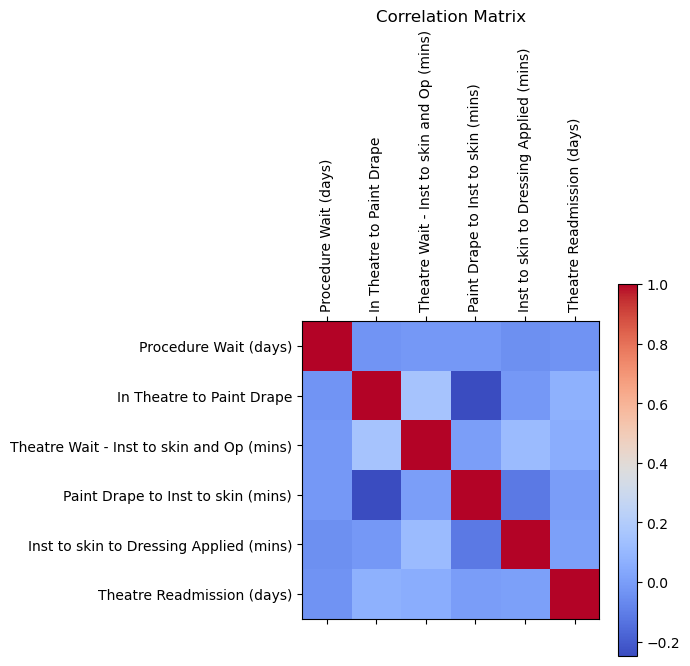

In [214]:
scale_corScale(cardiac_elective['Procedure Wait Time (Days)'], "Procedure Wait (days)", cardiac_elective['InOpTheatre to PaintDrape (Mins) Ave Drape Yes'], "In Theatre to Paint Drape", cardiac_elective['Theatre Wait (Mins) Ave Inst to skin and op Yes'], "Theatre Wait - Inst to skin and Op (mins)", cardiac_elective['PaintDrape to InstrToSkin (Mins) Ave Skin Yes'], "Paint Drape to Inst to skin (mins)", cardiac_elective['InstrToSkin to DressAppl (Mins) Ave Dressing Yes'], "Inst to skin to Dressing Applied (mins)", cardiac_elective['Theatre Readmission Days'], "Theatre Readmission (days)")
            